In [3]:
import os
from datetime import datetime
from typing import List, Optional, Tuple

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# === Function Definitions ===
def build_files_from_runs(root: str, prefix: str, runs: List[int], ext: str) -> List[str]:
    """Construct absolute paths to outsim files from run numbers."""
    return [os.path.join(root, f"{prefix}{r}{ext}") for r in runs]


def infer_ylabel_from_compname(compname: Optional[str]) -> str:
    """Map CompName (type) to a sensible y-axis label."""
    if not compname:
        return "Output"
    t = compname.strip().upper()
    if t == "RESERV":
        return "Storage (dam³)"
    if t == "IRRIGAT":
        return "Consumptive Use (cms)"
    return "Flow (cms)"  # NATCHL, DIVCHL, etc.


def read_outsim_one(path: str) -> Tuple[pd.DataFrame, List[str]]:
    """
    Read one outsim CSV where headers are stored in row 0, then drop that row.
    Returns the dataframe and a sorted list of Interval_* columns.
    """
    df = pd.read_csv(path, header=None)
    df.columns = df.iloc[0]
    df = df.drop(index=0).copy()

    for col in ("Year", "CompNum"):
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    interval_cols = [c for c in df.columns if str(c).startswith("Interval_")]
    interval_cols = sorted(interval_cols, key=lambda x: int(x.split("_")[1]))
    return df, interval_cols


def melt_with_dates(df: pd.DataFrame, interval_cols: List[str]) -> pd.DataFrame:
    """Melt Interval_1..52 and build a real Date using WRMM’s fixed week mapping."""
    long_df = df.melt(
        id_vars=[c for c in df.columns if c not in interval_cols],
        value_vars=interval_cols,
        var_name="Interval",
        value_name="Value",
    )
    long_df["Interval"] = long_df["Interval"].str.replace("Interval_", "", regex=False).astype(int)
    long_df["Value"] = pd.to_numeric(long_df["Value"], errors="coerce")

    def to_date(row):
        y = int(row["Year"])
        mmdd = WEEK_DATES[row["Interval"] - 1]  # 1-based
        return datetime.strptime(f"{y}-{mmdd}", "%Y-%m-%d")

    long_df["Date"] = long_df.apply(to_date, axis=1)
    return long_df


def load_prepare_timeseries(
    files: List[str],
    compnum: int,
    start_date: Optional[str],
    end_date: Optional[str],
    date_fmt: str,
) -> Tuple[pd.DataFrame, Optional[str]]:
    """Load multiple files, filter by CompNum, melt to long with dates, return combined df + detected CompName."""
    start_dt = datetime.strptime(start_date, date_fmt) if start_date else None
    end_dt = datetime.strptime(end_date, date_fmt) if end_date else None

    frames = []
    compname_detected: Optional[str] = None

    for path in files:
        if not os.path.isfile(path):
            raise FileNotFoundError(f"File not found: {path}")

        df, interval_cols = read_outsim_one(path)
        df = df[df["CompNum"] == compnum].copy()
        if df.empty:
            continue

        if compname_detected is None and "CompName" in df.columns and not df["CompName"].isna().all():
            compname_detected = str(df["CompName"].iloc[0])

        long_df = melt_with_dates(df, interval_cols)
        out = long_df[["Date", "Value"]].copy()
        out["Run"] = os.path.splitext(os.path.basename(path))[0]  # legend label

        if start_dt:
            out = out[out["Date"] >= start_dt]
        if end_dt:
            out = out[out["Date"] <= end_dt]

        out = out.dropna(subset=["Value"]).sort_values(["Run", "Date"])
        frames.append(out)

    if not frames:
        raise ValueError(f"No data found for CompNum {compnum} in the given files/date window.")

    return pd.concat(frames, ignore_index=True), compname_detected


def plot_timeseries(
    df: pd.DataFrame,
    compnum: int,
    compname: Optional[str],
    title_prefix: str,
    figsize=(14, 6),
    linewidth=1.2,
    show_grid=True,
    save_png=False,
    png_path="plot.png",
):
    """Render the multi-run comparison plot."""
    ylabel = infer_ylabel_from_compname(compname)

    plt.figure(figsize=figsize)
    for run, group in df.groupby("Run"):
        plt.plot(group["Date"], group["Value"], label=run, linewidth=linewidth)

    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(f"{title_prefix}: {(compname or 'Component')} ({compnum})")
    if show_grid:
        plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_png:
        plt.savefig(png_path, dpi=200, bbox_inches="tight")
    plt.show()



In [5]:
# Plot/output controls
TITLE_PREFIX = "Multi Run Comparison"
SAVE_PNG = False
PNG_PATH = "multi_run_comparison.png"
FIGSIZE = (14, 6)
LINEWIDTH = 1.2
SHOW_GRID = True

# WRMM fixed 52-week calendar (Interval 1..52)
WEEK_DATES = [
    "01-07", "01-14", "01-21", "01-28",
    "02-04", "02-11", "02-18", "02-25",
    "03-04", "03-11", "03-18", "03-25",
    "04-01", "04-08", "04-15", "04-22", "04-29",
    "05-06", "05-13", "05-20", "05-27",
    "06-03", "06-10", "06-17", "06-24",
    "07-01", "07-08", "07-15", "07-22", "07-29",
    "08-05", "08-12", "08-19", "08-26",
    "09-02", "09-09", "09-16", "09-23", "09-30",
    "10-07", "10-14", "10-21", "10-28",
    "11-04", "11-11", "11-18", "11-25",
    "12-02", "12-09", "12-16", "12-23", "12-31"
]



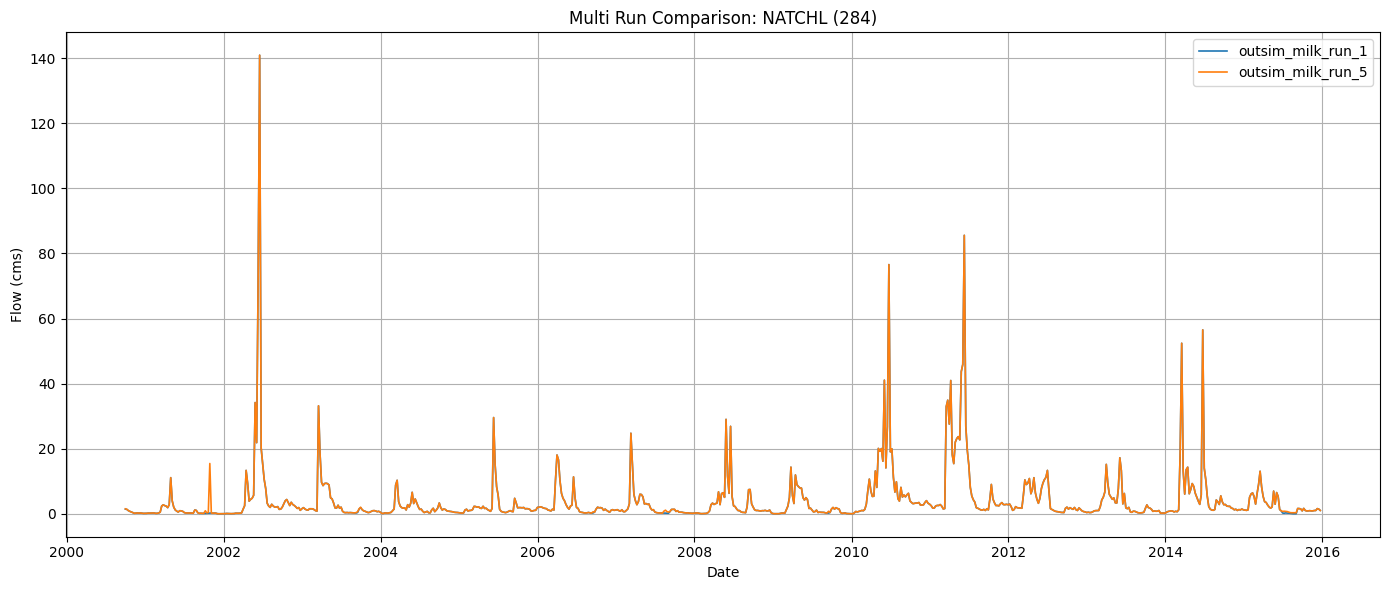

In [22]:
# === Main Executable ===

ROOT_PATH = '/Users/alexandergiberson/Documents/Masters_Work/WRM_TWG_CREDIT_RUNS/Capped_Credit_Run_600cfs'

# Build the list of CSVs from run numbers and a prefix/suffix (keeps things tidy)
RUN_NUMBERS: List[int] = [1,5]
OUTSIM_BACKUP_PREFIX = "outsim_milk_run_" #outsim_stmr_run_ outsim_milk_run_
BACKUP_EXT = ".csv"

# WRMM selection + date window
COMPNUM = 284

START_DATE = "2000-09-30"   # or None for full range
END_DATE   = "2015-12-23"   # or None for full range
DATE_FMT = "%Y-%m-%d"

if __name__ == "__main__":
    files_to_compare = build_files_from_runs(
        ROOT_PATH, OUTSIM_BACKUP_PREFIX, RUN_NUMBERS, BACKUP_EXT
    )

    combined, compname = load_prepare_timeseries(
        files=files_to_compare,
        compnum=COMPNUM,
        start_date=START_DATE,
        end_date=END_DATE,
        date_fmt=DATE_FMT,
    )

    plot_timeseries(
        df=combined,
        compnum=COMPNUM,
        compname=compname,
        title_prefix=TITLE_PREFIX,
        figsize=FIGSIZE,
        linewidth=LINEWIDTH,
        show_grid=SHOW_GRID,
        save_png=SAVE_PNG,
        png_path=PNG_PATH,
    )